# Nonzero Input, Gaussian Model

## Dependencies

In [62]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img
from torch.utils.data import DataLoader, Subset
import random

## Device Select

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [64]:
###- DS LOCATION CONFIRMATION -###

jubin_ds = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(jubin_ds):
    print(f"YES! File found at: {jubin_ds}")
else:
    print(f"Error: File not found at: {jubin_ds}")
    
# loads ds
fmri = nib.load(jubin_ds)
fmri.shape

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


(91, 109, 91, 1200)

## Volume and Slice Selection

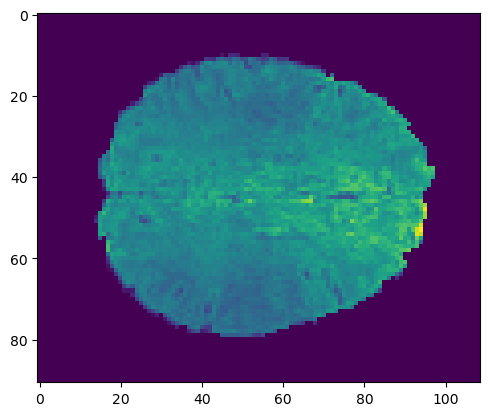

In [88]:
###- GET VOLUME AT TIMEPOINT, GET SLICE FROM VOLUME -###

# gets volume
single_volume = index_img(fmri, 50)
arr = single_volume.get_fdata()

# sets timepoint
timepoint = 50

# takes 50th slice of volume, 50th timepoint
slice = arr[:,:, timepoint]

plt.imshow(slice)

## Normalization and Saving

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)
0 255 (91, 109)


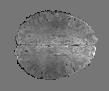

In [86]:
###- NORMALIZE SLICES -###

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalizes 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)


#--- SAVE GT IMAGE AND ARRAY ---#

np.save('ground_truth.npy', norm_slice)

min_val = norm_slice.min()
max_val = norm_slice.max()

# scale 2d slice to fit image format and convert the scaled data to unsigned 8-bit integers 
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

img.show()

## Build Dataframe

In [90]:
###- BUILD DATAFRAME (NON-ZERO PIXELS ONLY) -###

# transpose the normalized slice from (91, 109) to (109, 91) so height=109, width=91
bw_array = norm_slice.T
height, width = bw_array.shape
print(f"shape of transposed slice: {bw_array.shape}")

# create a boolean mask to identify the non-zero pixels (the brain region)
brain_mask = bw_array != 0

# use np.where to get the coordinates (indices) of the brain pixels
# y_coords will be row indices (0-108), x_coords will be column indices (0-90)
y_coords, x_coords = np.where(brain_mask)

# extract the intensity values for only the brain pixels using the mask
intensity_vals = bw_array[brain_mask]

num_brain_pixels = len(intensity_vals)
print(f"brain pixels: {num_brain_pixels} out of {height * width} total pixels.")

# normalize the coordinates of the brain pixels to the [0, 1] range
x_pos_norm = x_coords / (width - 1)
y_pos_norm = y_coords / (height - 1)

# to normalize intensity, find the min and max of the BRAIN region only
min_int = intensity_vals.min()
max_int = intensity_vals.max()
print(f"intensity range of brain pixels: [{min_int:.4f}, {max_int:.4f}]")

# normalize the brain intensities to the [0, 1] range
intensity_norm = (intensity_vals - min_int) / (max_int - min_int)

# create the DF using only the segmented brain data
df = pd.DataFrame({
    "x_pos": x_pos_norm,
    "y_pos": y_pos_norm,
    "intensity": intensity_norm
})

df.head()


shape of transposed slice: (109, 91)
brain pixels: 4502 out of 9919 total pixels.
intensity range of brain pixels: [-4.4632, 5.1290]


,x_pos,y_pos,intensity
0,0.555556,0.129630,0.068146
1,0.566667,0.129630,0.126463
2,0.400000,0.138889,0.261006
3,0.411111,0.138889,0.301404
4,0.422222,0.138889,0.339302


## Initialize Model

In [91]:
class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   


    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)

        return x

## Positional Encoding

In [92]:
# pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1)  

In [93]:
# dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        if (fourier or gaussian) == False:
            #No positional encoding, just x and y
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #fourier encoding with just cos/sin 2x and 2y
                freq = [1, 1]
            elif gaussian == True:
                #normal random sample num_freq frequencies for cos and sin to include in positional encoding
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale

                #Need to save these frequencies because they must also be used for pos encoding inputs at inference time
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                #if you want to pass in custom frequencies
                freq = freq_param

            x = dataframe['x_pos']
            y = dataframe['y_pos']
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Seeding

In [100]:
###- CREATES A SEED TP RANDOMIZE PIXEL GRID -###

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # if using multi-GPU, these lines ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"SEED SET TO: {seed}")

## Training

In [99]:
###- MAIN TRAINING CELL -###

def train( num_freq, model_type, model_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1):
    epoch_losses = []
    min_loss = 100
    
    if model_type == 'fourier':
        data = ImageINRDatasetFourier(df, fourier = True, num_freq = 1)
        model = ImageINRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDataset(df)
        model = ImageINRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        model = fMRI_INRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDataset(df)
        model = INR(2, 256, 4, 3).to(device)
    else:
        print('invalid model_type')
        return
    
    train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 1000

    for epoch in tqdm(range(num_epochs)):
        model.train()

        epoch_loss = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()


        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
            epoch_losses.append(epoch_loss)
            pickle.dump(epoch_losses, open(f"{loss_file}_losses.pkl", "wb"))
            if epoch_loss < min_loss:

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }

                torch.save(checkpoint, model_file)

## RUN TO TRAIN MODEL

In [96]:
train(
    num_freq = 256, 
    model_type = 'gaussian', 
    model_file ='NZ_run.pth', 
    loss_file = 'NZ_loss', 
    freq_file = 'NZ.pkl', 
    gauss_scale = 10
)

  0%|          | 1/1000 [00:00<04:07,  4.03it/s]

Epoch 0, Loss: 0.2216728776693344


 10%|█         | 101/1000 [00:03<00:44, 20.28it/s]

Epoch 100, Loss: 0.004455632530152798


 20%|██        | 201/1000 [00:07<00:36, 21.78it/s]

Epoch 200, Loss: 0.004260593093931675


 30%|███       | 300/1000 [00:11<00:27, 25.52it/s]

Epoch 300, Loss: 0.00241468264721334


 40%|███▉      | 398/1000 [00:15<00:20, 29.34it/s]

Epoch 400, Loss: 0.001592995598912239


 50%|█████     | 501/1000 [00:20<00:26, 18.84it/s]

Epoch 500, Loss: 0.0011114032240584493


 60%|██████    | 600/1000 [00:24<00:19, 20.45it/s]

Epoch 600, Loss: 0.0007474460871890187


 70%|██████▉   | 699/1000 [00:28<00:11, 27.30it/s]

Epoch 700, Loss: 0.0005396157503128052


 80%|████████  | 801/1000 [00:32<00:11, 17.83it/s]

Epoch 800, Loss: 0.0005324924131855369


 90%|█████████ | 901/1000 [00:36<00:04, 21.52it/s]

Epoch 900, Loss: 0.00045995000982657075


100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


## Visualization

Reconstructing for dimensions: 109x91
Shape of encoded coordinate grid: torch.Size([9919, 1024])
tensor(0.0730, dtype=torch.float64)
reconstructed


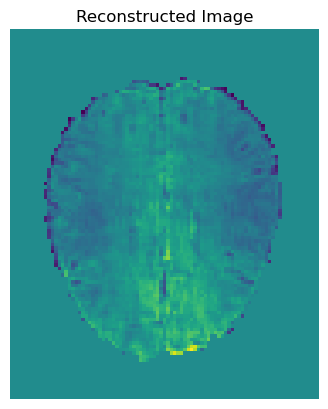

gt


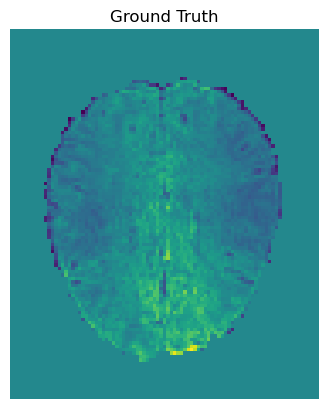

dif


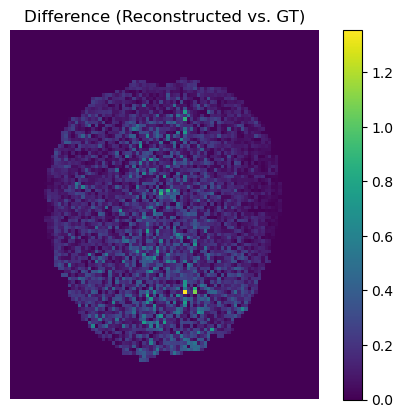

In [97]:
# Re-define the model architecture for inference
num_freq = 256
model = fMRI_INRModel(input_size = 4*num_freq) 

# Define path to the saved model checkpoint 
path = './NZ_run.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Get the original image dimensions (after transpose)
H, W = norm_slice.T.shape
print(f"Reconstructing for dimensions: {H}x{W}")

# Create a coordinate grid for the entire image space
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)

# This ensures the coordinate grid is created in the correct row-major order
X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)

# Load the frequencies used during training for positional encoding
with open('./NZ.pkl', 'rb') as file:
    freq = pickle.load(file)

# Apply the same fourier encoding to the full coordinate grid
X_encoded = fourier_encode(X, freq = freq)
print(f"Shape of encoded coordinate grid: {X_encoded.shape}")

# Perform inference
with torch.no_grad():
    Y = model(X_encoded) 

# Reshape the output back into an image and un-normalize it.
min_int = norm_slice[norm_slice != 0].min()
max_int = norm_slice.max()
image_normalized_output = Y.reshape(H, W, 1)
image_unnormalized = (image_normalized_output * (max_int - min_int)) + min_int

### FIX: Apply Brain Mask to Remove Background Artifacts ###
# 1. Create a boolean mask from the original transposed slice (True for brain, False for background)
brain_mask_np = (norm_slice.T != 0) 
# 2. Convert the numpy mask to a PyTorch tensor, add a channel dimension, and convert to float for multiplication
brain_mask_tensor = torch.from_numpy(brain_mask_np).unsqueeze(-1).float()
# 3. Multiply the reconstructed image by the mask. This sets all background pixels to zero.
reconstructed_masked = image_unnormalized * brain_mask_tensor
### END FIX ###

# Create the ground truth image from the original DataFrame for comparison
gt_array = np.zeros((H, W))
y_indices = (df['y_pos'] * (H - 1)).round().astype(int).values
x_indices = (df['x_pos'] * (W - 1)).round().astype(int).values
gt_unnormalized_intensities = (df['intensity'].values * (max_int - min_int)) + min_int
gt_array[y_indices, x_indices] = gt_unnormalized_intensities
gt_tensor_unnormalized = torch.from_numpy(gt_array).unsqueeze(-1)

# Calculate the difference image
diff_image = torch.abs(gt_tensor_unnormalized - reconstructed_masked).squeeze()
print(diff_image.mean())


print('reconstructed')
plt.imshow(reconstructed_masked.squeeze())
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

print('gt')
plt.imshow(gt_tensor_unnormalized.squeeze())
plt.title('Ground Truth')
plt.axis('off')
plt.show()

print('dif')
plt.imshow(diff_image)
plt.title('Difference (Reconstructed vs. GT)')
plt.colorbar()
plt.axis('off')
plt.show()
